# Spatial Regression (Part 1)

_"Everything is related to everything, but near things are more related than distant things"_ - [Waldo Tobler](https://en.wikipedia.org/wiki/Waldo_R._Tobler)

This law of Geography can be translated to the language of Statistics as: things nearby are more alike and thus we can expect them to be positively correlated. The core idea behind Spatial Statistics is to understand an characterize this spatial dependence that is observed in different processes, for example: amount of rainfall, global temperature, air pollution, etc.

Spatial dependence, as a concept, started to be formally addressed by statisticians at the begining of the XX century (Fisher, 1935). However, it was until the second half of the century when 
Matheron (1962, 1963) and Gandin (1963) developed a [_best linear unbiased predictor_ (blup)](https://en.wikipedia.org/wiki/Best_linear_unbiased_prediction) for spatial modeling. Kriging, as the predictor is known, became the standard modeling approach of continuous spatial variation. 

Geostatistical methods have traditionally been related to data observed at a set of spatial locations indexed in a continuous space. This is as opposed to lattice methods and point pattern methods. The former related to
data observed on a fixed set locations and the latter used for data associated to a point process. Diggle et al. (2013) consider that distinctions based on data formats are not always appropriate. They argue that the main theoretical distinction within spatial statistics is the continuity or non-continuity of the process being modeled. The model-based approach (Diggle et al., 1998) has become the current paradigm for modelling variability and quantifying uncertainty: a hierarchical thinking that explicitly assumes a stochastic model, but also acknowledges a different uncertainty in the data and in the parameters of the process (Cressie and Wikle, 2011).

## Code for the Session

Along the discussion we will show some interactive examples. We will use some auxiliary code for running these examples, which will be available for everybody to download. The following packages need to be preinstalled for the code of this session to work:

In general, we will call the methods of the packages as:

This is as opposed to loading the package and calling the method directly:

We will do this so that it is explicit which method belongs to which package. The exceptions to this rule will be _ggplo2_ and _Rccp_. 
The former because otherwise notation becomes too long and less readable when making plots, and the latter because otherwise we will run into problems when calling _rstan_. 

The commmand below will load ggplot, Rcpp and the auxiliary code needed for the session.

In [41]:
library(ggplot2)
library(Rcpp) 
source("r_code/auxiliary_functions.R")
source("r_code/jupyter_stuff.R") # Only needed if using jupyter

The command below will fix the size of the plots diplayed. It is not necessary, but will help us along this interactive session.

In [ ]:
options(repr.plot.width=5, repr.plot.height=4)

## Outline

1. Linear Regression
2. Trend Surface
3. Covariance Functions
5. Gaussian Processes
6. Cross Validation

## 1. Linear Regression

As a first step it will be convenient to have a brief recap on linear regresson. Let $\{y_i, x_{i1}, \ldots, x_{ip}\}_{i=1}^n$ be a set of dependent and explanatory variables. In Ordinary Least Squares we usually want to estimate the parameters $\{\beta_j\}_{j=0}^{p}$ that best fit the model:

$y_i = \beta_0 + \beta_1  x_{i1} + \ldots + \beta_j x_{ip} + \epsilon_i$ for $i = 1, \ldots, n$.

where $\epsilon_i$ a Gaussian random variable with mean zero. The parameters choosen are the ones that generate the hyperplane that is closest on average to all the points $x_{ij}$.

In [ ]:
# Generate some toy data
reg_data <- lm_data(seed=0)
reg_data$type <- 'observed'

# Fit linear model
model1 <- lm(y ~ x, data=reg_data)

# Predictions
x_linspace <- seq(.5, 2.5 * pi, length.out=100) 
to_append <- data.frame(x=x_linspace, 
                        y=predict(model1, newdata=data.frame(x=x_linspace)),
                        type='order_1')
reg_data <- rbind(reg_data, to_append)

# Plot results
plt <- ggplot(data=subset(reg_data, type=='observed'), aes(x, y)) + 
        geom_point(col="steelblue", size=2) + 
        geom_line(data=subset(reg_data, type=='order_1'), col="red") +
        ggtitle(label = "Linear Regression Example") + 
        theme_minimal()
publish_gg(plt)

Sometimes (almost everytime) a straight line is not enough to explain the relationship between $x_i$ and $y_i$. This usually makes us start thinking of some polynomial regression that is more adequate. For example:

Order 2: $y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \epsilon_i$

Order 3: $y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \epsilon_i$




In [ ]:
n_poly <- 4
poly_data <- reg_data
for (i in 2:n_poly) {
    new_dataset <- subset(reg_data, type=='observed')[,-c(3)]
    new_linspace <- data.frame(x=x_linspace)
    for (j in 2:i) {
        new_dataset[paste0("x", j)] <- new_dataset$x^j
        new_linspace[paste0("x", j)] <- new_linspace$x^j
    }
    m <- lm(y ~ ., data = new_dataset)
    to_append <- data.frame(x=x_linspace, 
                            y=predict(m, newdata=new_linspace), 
                            type=paste("order", i, sep="_"))
    poly_data <- rbind(poly_data, to_append)
}

In [ ]:
# Plot results
plt <- ggplot(data=subset(poly_data, type=='observed'), aes(x, y)) + 
        geom_point(col="steelblue", size=2) + 
        geom_line(data=subset(poly_data, type!='observed'), aes(color=type)) +
        ggtitle(label = "Polynomial Regression Example") + 
        theme_minimal()
publish_gg(plt)

**Q:** Which of the lines is a better fit to the given points?

## 2. Trend Surface

Linear regression models can be used to summarize the variation in spatial patterns. A trend surface of order $n$ can be estimated by applying a regression model using the spatial coordinates as the independent variables. For example, let the longitude and latitude coordinates be defined as $x_{i1}$ and $x_{i2}$ respectively, then we can describe the following trend surfaces:

Order 1: $y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \beta_3 x_{i1} x_{i2} + \epsilon_i$

Order 2: $y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \beta_3 x_{i1} x_{i2} + \beta_4 x_{i1}^2 + \beta_5 x_{i2}^2 + \epsilon_i $

Note that we are also adding the product $x_{i1} x_{i2}$. This is a term that accounts for the interactions.

Having a trend across the surface seems like a good idea. Now, we will make a new toy dataset to see how this approach works.

## Soil Survey

Imagine that we have a plot of $400m \times 400 m$ where we want to study a specific property of the soil, we will call it _soiliness_. We pick different locations at random and take measurments of soiliness.

In [ ]:
spatial_reg <- soil_data(n_peaks=2, n_data = 150, seed=0)
head(spatial_reg)

In [ ]:
gg <- ggplot(spatial_reg, aes(lng, lat)) + 
        geom_point(aes(col=soiliness), size=2.5) +
        viridis::scale_color_viridis(option="plasma") +
        ggtitle("Clustered Spatial Data") +
        theme_minimal()
publish_gg(gg)

## Fitted Surfaces

In [ ]:
# Fit a model with a trend of order 1
surf_order1 <- lm(soiliness ~ lng * lat, data=spatial_reg)

# Fit a model with a trend of order 2
surf_order2 <- lm(soiliness ~ lng * lat + I(lng^2) + I(lat^2), data=spatial_reg)

In [ ]:
# Grid for predictions
surf_grid <- as.data.frame(make_grid(size = 20))

surf_grid$surface_o1 <- predict(surf_order1, newdata=surf_grid)
surf_grid$surface_o2 <- predict(surf_order2, newdata=surf_grid)

plt <- ggplot(surf_grid, aes(lng, lat)) + 
        geom_raster(aes(fill=surface_o1)) +
        geom_contour(aes(z=surface_o1), col="white", linetype=1, alpha=.5) +
        geom_point(data=spatial_reg, aes(fill=soiliness), colour="white", pch=21, size=3) +
        viridis::scale_fill_viridis(option="plasma", na.value="darkblue") +
        ggtitle("Trend Surface: Order 1") +
        theme_minimal()
publish_gg(plt)

**Q:** How would the surface look if we hadn't included the interaction term $x_i x_j$?

In [ ]:
plt <- ggplot(surf_grid, aes(lng, lat)) + 
        geom_raster(aes(fill=surface_o2)) +
        geom_contour(aes(z=surface_o2), col="white", linetype=1, alpha=.5) +
        geom_point(data=spatial_reg, aes(fill=soiliness), colour="white", 
                   pch=21, size=3) +
        ggtitle("Trend Surface Order 2") +
        viridis::scale_fill_viridis(option="plasma", na.value="darkblue") +
        theme_minimal()
publish_gg(plt)

**Q:** How does a surface of a higher order look like?

It may be the case that for some purpose a surface like the one above is a model good enough. It also can happen that such a model is not good. 

_Can we get a fit that resembles more what the data looks like?_ The answer is yes, as we will see next.

## 3. Covariance Functions

What we need from a model to produce a better fit is that it works under the assumption that points which are close are likely to have similar target values (n_positive in this case). In other words, we expect the observed target values to change together across space.

When want to measure how much two variables change together, we use the covariance function. Under the right assumptions, we can also use the covariance function to describe the similarity of the observed values based on their location.

**Covariance function:** A function $K: S \times S → R$ is a covariance function if it is continuous, symmetric and positive definite.

For example, assume that $S \subset R^2$ and that 
$r = ||(x_{i1},x_{i2})^\top - (x_{j1},x_{j2})^\top ||$.

The **_exponentiated quadratic_** or **_RBF_** covariance function is defined as

$K(x_i, x_j) = \sigma^2 exp \left( \frac{- r^2 }{ 2  \ell^2} \right)$

for some positive parameters $\sigma$ and $\ell$.


The **_rational quadratic_** covariance function is defined as

$K(x_i, x_j) = \sigma^2   \left( 1 + \frac{ r^2 }{ 2 \alpha \ell^2} \right) ^{-\alpha}$

for some positive parameters $\sigma$, $\alpha$ and $\ell$.

The **_power exponential_** covariance function is defined as

$K(x_i, x_j) = \sigma^2   exp\left( - \left(\frac{ r }{ \ell} \right) ^{\gamma} \right)$

for some positive parameters $\sigma$ and $\ell$.

The election of which covariance function to use depends on our assumptions about the change in the association between the points across space (eg., the speed of decay).


In [ ]:
x_0 <- as.matrix(0, nrow=1, ncol=1)
x_linspace <- as.matrix(seq(-8, 8, length.out = 100), ncol=1)
kval <- c(as.numeric(rbf(x_0, x_linspace, sigma=1, lengthscale=1)),
       as.numeric(rqd(x_0, x_linspace, sigma=1, lengthscale=1, alpha=1)),
       as.numeric(pow(x_0, x_linspace, sigma=1, lengthscale=1, gamma=1)))
kname <- c(rep("exp_quad", 100), rep("rat_quad", 100), rep("pow_exp", 100))
covdf <- data.frame(x=rep(x_linspace, 3), k=kval, covariance= kname)


plt <- ggplot(covdf, aes(x, k)) + geom_line(aes(col=covariance)) +
        ggtitle("Different Covariance Functions") +
        theme_minimal()
publish_gg(plt)

Here is an example in 2 dimensions to illustrate the concept of the covariance function. Suppose we have 10 locations randomly selected in our in our $400m \times 400m$ plot.

In [ ]:
xx <- random_points_ordered(n_points = 10, seed=0)

plt <- ggplot(as.data.frame(xx), aes(lng, lat)) + 
        geom_point(col="steelblue", size=2.5) + 
        theme_minimal()
publish_gg(plt)

Based on the pairwise distances between the points, the resulting covariance matrix under a Rational Quadratic model is the following.

In [ ]:
K <- rqd(xx, xx, lengthscale=20, alpha=2)
kdf <- data.frame(k = as.vector(K), 
                  point_i = factor(rep(10:1, 10)), 
                  point_j = factor(sort(rep(1:10, 10), decreasing=TRUE)))

plt <- ggplot(kdf, aes(point_j, point_i)) +
        geom_raster(aes(fill=k)) +
        viridis::scale_fill_viridis(option="plasma") +
        ggtitle("Covariance Matrix") +
        scale_y_discrete(limits=rev(levels(kdf$point_i))) +
        theme_minimal()
publish_gg(plt)

It is not only the shape of the covariance function that matters, but also the values of its parameters: $\sigma$, $\ell$, $\gamma$, etc. We will come back to that later.

## 4. Gaussian processes

Now that we have discussed how the covariance function can help describe properties we observe in our data, we can discuss how to incorporate this ideas into a model. 

Before, we mentioned that a surface trend could be modeled as 

$y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \beta_3 x_{i1} x_{i2} + \epsilon_i$.

Instead we will model our data as 

$y_i = f_i(x_i) + \epsilon_i$,

where $f = (f_1, \ldots, f_n)^\top$ is a multivariate normal distribution.

_Why?_ A Gaussian distribution is completely defined by its first two moments. Moreover, a centered Gaussian distribution is uniquely defined by its covariance. This means that in our new model, for every $y_i$ we will have now an underlying gaussian variable $f_i$ with the property that all ${f_i}$ have a spatial dependance structure given by $K(x_i, x_j)$.

**Gaussian process:** A Gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution.

We denote a Gaussian process with mean function $m$ and covariance function $K$ as $f(x) \sim \mathcal{GP}\big(m(x), K(x, x)\big)$.

While in the linear regression model we estimate the $\beta$ parameters, here we estimate the values of $f_i$ at the input locations $x_i$. We have to be aware that $f_i$ are not parameters in the sense of classical statistics, they are random variables and we will handle them under a Bayesian approach. Given the observed data $\{x, y\}$, the posterior distribution of $f$ is given by:

$p(f|y,x) \propto p(y|f,x) p(f|x)$

We will assume for the moment that $m(x)=0$. This is a common assumption that doesn't reduce the flexibility of the method, but simplifies handling it. Notice $\epsilon = (\epsilon_1, \ldots, \epsilon_n)^\top$ is joint Gaussian with mean zero and Covariance matrix $I \sigma^2_\epsilon$. Thus $y \sim N(0, K(x,x) + I\sigma^2_\epsilon)$. Then it turns out that $f_\ast|y,x$ (posterior of $f$ at new locations $x_\ast$) is multivariate Gaussian with mean

$E(f_\ast|y,x) = K(x_\ast,x)(K(x,x) + I\sigma^2_\epsilon)^{-1}y$ 

and covariance

$Var(f_\ast|y,x) =K(x_\ast,x_\ast) - K(x_\ast,x)(K + I\sigma^2_\epsilon)^{-1}  K(x, x_\ast)$.

Usually, we want to predict new realizations of $y_\ast$, instead of $f_\ast$. The predictive values of $y_\ast$, given the observations are computed as 

$p(y_\ast|y,x) =  \int p(y_\ast  |f_\ast) p(f_\ast|y,x) df_\ast$.

In this case, since $y$ is just a noisy version of $f$ where the noise is Gaussian with zero mean, it turns out that 

$E(y_\ast|y,x) = K(x_\ast,x)(K(x,x) + I\sigma^2_\epsilon)^{-1}y$ 

and

$Var(y_\ast|y,x) =K(x_\ast,x_\ast) - K(x_\ast,x)(K + I\sigma^2_\epsilon)^{-1}  K(x, x_\ast) + I\sigma^2_\epsilon$.

Going back to our soil example, this is how a Gaussian process regression fit looks like.

In [ ]:
# For the moment we will assume that the following quantities are known
rbf_sigma <- 20
rbf_lengthscale <- 25
epsilon_sigma <- 10

# These are the locations of the train set and predictions
X <- as.matrix(spatial_reg[, c("lng", "lat")])
X_star <- as.matrix(surf_grid[, c("lng", "lat")])

# Output value
Y <- as.matrix(spatial_reg$soiliness)

# Fit a Gaussian process
gp_fit <- gp_regression_rbf(X, Y, X_star, k_var=rbf_sigma^2, k_len=rbf_lengthscale, noise_var=epsilon_sigma^2)
surf_grid$surface_gp_mean <- gp_fit$gp_mean
surf_grid$surface_gp_var <- gp_fit$gp_var

In [ ]:
plt <- ggplot(surf_grid, aes(lng, lat)) + 
        geom_raster(aes(fill=surface_gp_mean)) +
        geom_contour(aes(z=surface_gp_mean), col="white", linetype=1, alpha=.5) +
        #geom_point(data=spatial_reg, aes(fill=soiliness), colour="white", pch=21, size=3) +
        viridis::scale_fill_viridis(option="plasma", na.value="darkblue") +
        ggtitle("Gaussian Process - Predictive Mean") +
        theme_minimal()
publish_gg(plt)

In [ ]:
plt <- ggplot(surf_grid, aes(lng, lat)) + 
      geom_raster(aes(fill=surface_gp_var)) +
      geom_contour(aes(z=surface_gp_var), col="white", linetype=1, alpha=.5) +
      geom_point(data=spatial_reg, colour="white", pch=21, size=3) +
      viridis::scale_fill_viridis(option="plasma", na.value="darkblue") +
      ggtitle("Gaussian Process - Predictive Variance") +
      theme_minimal()
publish_gg(plt)

Notice that the regions with no points have higher variance, while the regions with many points concentrated have a low variance. Remember that in the Bayesian approach, the variance is a measure of uncertainty. Thus, we are more uncertain about the process when there are no observations nearby and become more certain the more observations we have.

Since the Gaussian process is defined by its mean and covariance, these are usually the parameters we are mostly interested in estimating. However these are not the only parameters of the model. As we discussed before, the covariance functions have different parameters associated, for example $\sigma$, $\ell$ or $\gamma$. We usually refer to them as _hyperparameters_.

Below we will see how changes in the lengthscale affect the covariance function.

In [ ]:
x_0 <- as.matrix(0, nrow=1, ncol=1)
x_linspace <- as.matrix(seq(-8, 8, length.out = 100), ncol=1)

exp_quad <- c()
for (ell in c(.5, 1, 1.5, 2, 4)) {
    k <- rbf(x_0, x_linspace, sigma=1, lengthscale=ell)
    exp_quad <- rbind(exp_quad,
                      data.frame(x=x_linspace, 
                                 cov_function=as.numeric(k),
                                 lengthscale=paste0('lengthscale=',ell)))
}

plt <- ggplot(exp_quad, aes(x, cov_function)) + 
        geom_line(aes(color=lengthscale)) +
        ggtitle("Exponentiated Quadratic Covariance Function (sigma=1)") +
        theme_minimal()
publish_gg(plt)

In [ ]:
x_0 <- as.matrix(0, nrow=1, ncol=1)
x_linspace <- as.matrix(seq(-8, 8, length.out = 100), ncol=1)

rat_quad <- c()
for (ell in c(.5, 1, 1.5, 2, 4)) {
    k <- rqd(x_0, x_linspace, sigma=1, lengthscale=ell, alpha=.1)
    rat_quad <- rbind(rat_quad,
                      data.frame(x=x_linspace, 
                                 cov_function=as.numeric(k),
                                 lengthscale=paste0('lengthscale=',ell)))
}

plt <- ggplot(rat_quad, aes(x, cov_function)) + 
        geom_line(aes(color=lengthscale)) +
        ggtitle("Rational Quadratic Covariance Function (sigma=1, alpha=.1)") +
        theme_minimal()
publish_gg(plt)

**Q:** How does the function changes with different values of $\sigma$ and $\alpha$?

The values of the hyperparameters can also be chosen based on the data. While the optimal solutions for the posterior mean and variance have a nice and simple analytical expression, as we saw above, estimating optimal values for the hyperparamters is not that straightforward.

One solution is to use Markov Chain Monte Carlo methods to find their posterior distribution.
Notice that when taking into account the hyperparameters the posterior distribution of $f$ should be written as

$p(f|y,x,\theta) \propto p(y|f,\theta) p(f|x, \theta) $.

The normalizing constant of the expression above is given by

$p(y|x,\theta) = \int p(y|f,\theta) p(f|x, \theta) df$,

which can be used to calculate the posterior distribution of $\theta$:

$p(\theta|y,x) \propto p(y|x,\theta) p(\theta)$,

with normalizing constant 

$p(y|x) = \int p(y|x,\theta) p(\theta) d\theta$.

Solving the integral above can be a hard task. An alternative is to find the value of $\theta$ that maximizes the _marginal likelihood_ $p(y|x,\theta)$. Here the term marginal refers to the fact that $p(y|x,\theta)$ is computed after marginalizing the latent function $f$. By following this approach we are choosing the combination of $\theta$ values where the likelihood of the data observed $y$ is the highest. This approach is know as Maximum Likelihood type II.

Here we will use Monte Carlo methods to estimate the hyperparameters distribution and use the mean values as point estimates.

In [ ]:
fit_hyper <- rstan::stan(file="stan_code/gp_gaussian_fit_hyper.stan",
                         data=list(n_data = nrow(spatial_reg),
                                   n_dim = 2,
                                   y_data = spatial_reg$soiliness,
                                   X_data = spatial_reg[, c("lng", "lat")],
                                   mu_data = rep(0, nrow(spatial_reg))),
                         pars = c("noise_var", "cov_var", "cov_length"),
                         warmup = 1000, iter = 5000, chains = 4,
                         verbose = FALSE, seed=123)

In [ ]:
hyper_params <- rstan::extract(fit_hyper)
noise_var <- mean(cbind(hyper_params$noise_var))
cov_var <- mean(cbind(hyper_params$cov_var))
cov_length <- colMeans(cbind(hyper_params$cov_length))

Now we will plot the predicted surface with the point estimates.

Note: Our stan implementation considers a different lengthscale for each dimension in X, while our RBF function considers the same one. For the moment we will use as lengthscale value the average of both lenghtscale parameters. 

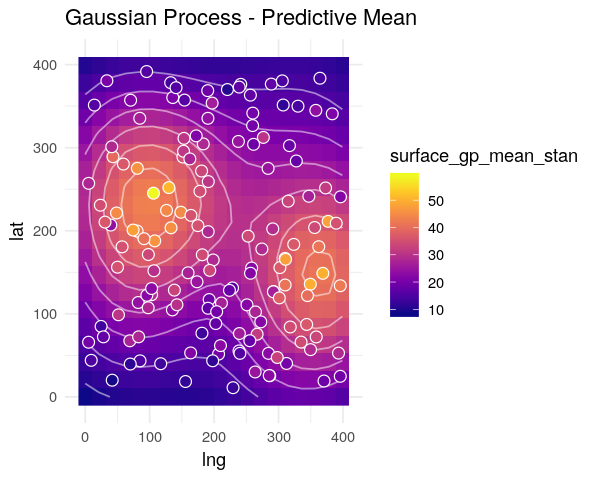

In [27]:
# Fit a Gaussian process
gp_fit_stan <- gp_regression_rbf(X, Y, X_star, k_var=cov_var, k_len=mean(cov_length), noise_var=noise_var)
surf_grid$surface_gp_mean_stan <- gp_fit_stan$gp_mean
surf_grid$surface_gp_var_stan <- gp_fit_stan$gp_var

# Plot predictive mean
plt <- ggplot(surf_grid, aes(lng, lat)) + 
      geom_raster(aes(fill=surface_gp_mean_stan)) +
      geom_contour(aes(z=surface_gp_mean_stan), col="white", linetype=1, alpha=.5) +
      geom_point(data=spatial_reg, aes(fill=soiliness), colour="white", pch=21, size=3) +
      viridis::scale_fill_viridis(option="plasma", na.value="darkblue") +
      ggtitle("Gaussian Process - Predictive Mean") +
      theme_minimal()
publish_gg(plt)

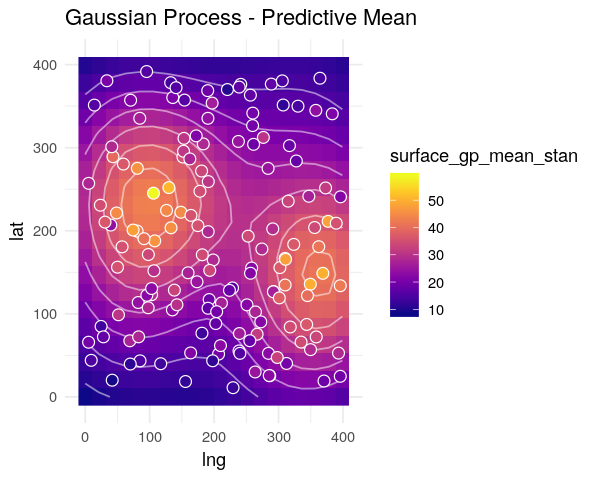

In [28]:
# Fit a Gaussian process
gp_fit_stan <- gp_regression_rbf(X, Y, X_star, k_var=cov_var, k_len=mean(cov_length), noise_var=noise_var)
surf_grid$surface_gp_mean_stan <- gp_fit_stan$gp_mean
surf_grid$surface_gp_var_stan <- gp_fit_stan$gp_var

# Plot predictive mean
plt <- ggplot(surf_grid, aes(lng, lat)) + 
      geom_raster(aes(fill=surface_gp_mean_stan)) +
      geom_contour(aes(z=surface_gp_mean_stan), col="white", linetype=1, alpha=.5) +
      geom_point(data=spatial_reg, aes(fill=soiliness), colour="white", pch=21, size=3) +
      viridis::scale_fill_viridis(option="plasma", na.value="darkblue") +
      ggtitle("Gaussian Process - Predictive Mean") +
      theme_minimal()
publish_gg(plt)

So far all the discussion has been around spatial location. _What about additional information we may have?_. We can have different approaches to include it.

For example, we can define a model as follows:

$y_i = \beta_0 + \beta_1 x_{i1} + \ldots + \beta_q x_{iq} + f(x_{is}) + \epsilon_i$, where

$\{x_{ij}\}_{j=1}^{q}$ are different covariantes and $x_{is}$ are spatial coordinates.

Another approach could be to use

$y_i = f(x^\ast_i) + \epsilon_i$, where $x^\ast_i$ is a vector that includes the spatial locations and other data features. In such a case, these features will also have a non-linear effect. For example, if the input vector contains spatial location and a temporal reference, $x^\ast = (x^{(s)}, x^{(t)})$,  a covariance function for a space-time process can be defined as:

$K(x^\ast_i, x^\ast_j) = \sigma^2 exp \left( -\frac{||x^{(s)}_i - x^{(s)}_j||^2 }{ 2  \ell^2_s} - \frac{||x^{(t)}_i - x^{(t)}_j||^2 }{ 2  \ell^2_t} \right)$.

Note that the expression above, is in fact the product of two covariance functions:

$K(x^\ast_i, x^\ast_j) = \sigma^2 exp \left( -\frac{||x^{(s)}_i - x^{(s)}_j||^2 }{ 2  \ell^2_s} \right) exp \left(- \frac{||x^{(t)}_i - x^{(t)}_j||^2 }{ 2  \ell^2_t} \right)$.

It is also possible to use sums of covariance functions to have additive effects of the form:
$y_i = f_1(x^\ast_i) + f_2(x^\ast_i) + \epsilon_i$.

## Cross-Validation

We have mentioned how to compute the posterior mean and variance. We also gave a brief description of how the hyperparameters can be estimated based on the data. Nevertheless, this does not tells us how to choose between different models. For example, given a covariance function we can optimize its hyperparameters, but _How do we choose between two models with different covariance functions?_ 

The idea behind cross-validation is to split the data we have into two disjoint sets: one for training and one to monitor the performance of the trained model. The performance is measured according to a criterion such as the sum of squared errors. Then the performance on the validation set is used as a proxy for the generalization error and model selection is carried out using this measure.

If the data avilalbe is scarse, holding out some data for validation may be far from ideal since the training and validation sets would be even scarser. A workaround this caveat is _k-fold cross-validation_: the data is split into k disjoint, equally sized subsets
; the model is trained k times, each one using a different subset for validation and the remaining for training. This way all elements in the dataset are used for validation and training.

The extreme case of having as many folds as data points is known as _leave-one-out cross-validation_ (LOO-CV).

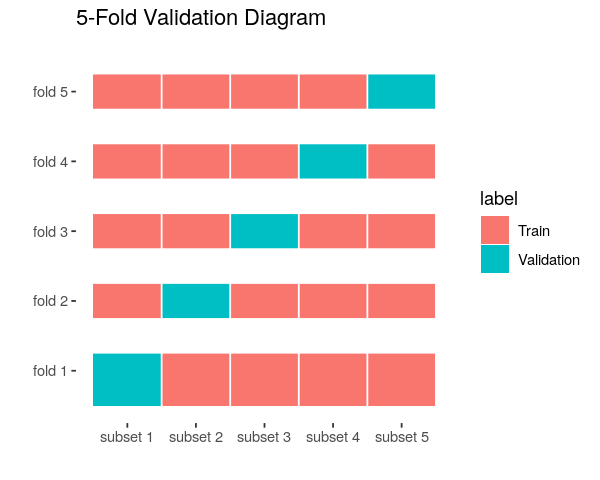

In [30]:
# K-fold validation diagram
k = 5
label_ <- rep("Train", k^2)
for(i in 1:k){
    label_[k*(i-1) +(k+1-i)] <- "Validation"
}
cvplot <- data.frame(x=rep(1:k, k), y=sort(rep(1:k, k), decreasing = TRUE), label=label_)

plt <- ggplot(cvplot, aes(x, y)) + geom_tile(aes(fill=label)) + 
        geom_vline(xintercept = 1:k + .5, col='white') +
        geom_hline(yintercept = 1:k + .5, col="white", size=10) +
        scale_y_continuous(breaks = 1:k, labels = paste("fold", 1:k)) +
        scale_x_continuous(breaks = 1:k, labels = paste("subset", 1:k)) +
        ggtitle(paste0(k, "-Fold Validation Diagram")) +
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank()) +
        ylab('') + xlab('')
publish_gg(plt)

Suppose we are choosing between a model with an Exponentiated Quadratic kernel and a model with a Rational Quadratic kernel, as shown below.

In [31]:
# RBF kernel
noise_var_1 <- 6
rbf_var <- 18
rbf_length <- 40

# Rational quadratic kernel
noise_var_2 <- 6
rqd_var <- 18
rqd_length <- 40
rqd_alpha <-1

surf_grid$model_1 <- gp_regression_rbf(X, Y, X_star, k_var=rbf_var, k_len=rbf_length, 
                                       noise_var=noise_var_1)$gp_mean
surf_grid$model_2 <- gp_regression_rqd(X, Y, X_star, k_var=rqd_var, k_len=rqd_length, 
                                       noise_var=noise_var_2, alpha=rqd_alpha)$gp_mean

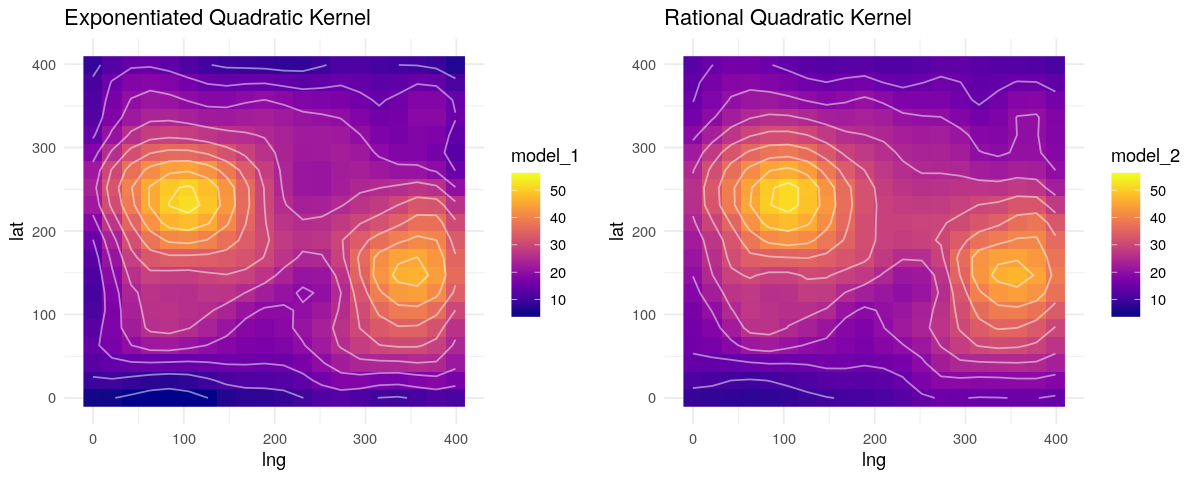

In [42]:
# Change dimensions to allow side by side display
options(repr.plot.width=10, repr.plot.height=4)

# Plot predictive mean
plt1 <- ggplot(surf_grid, aes(lng, lat)) + 
  geom_raster(aes(fill=model_1)) +
  geom_contour(aes(z=model_1), col="white", linetype=1, alpha=.5) +
  viridis::scale_fill_viridis(option="plasma", na.value="darkblue", lim=c(5,55)) +
  ggtitle("Exponentiated Quadratic Kernel") +
  theme_minimal()

plt2 <- ggplot(surf_grid, aes(lng, lat)) + 
  geom_raster(aes(fill=model_2)) +
  geom_contour(aes(z=model_2), col="white", linetype=1, alpha=.5) +
  viridis::scale_fill_viridis(option="plasma", na.value="darkblue", lim=c(5,55)) +
  ggtitle("Rational Quadratic Kernel") +
  theme_minimal()

plt <- cowplot::plot_grid(plt1, plt2)
publish_gg(plt)

We will compare this models using a 5-fold validation.

In [34]:
# Make an index with the k folds
ix = caret::createFolds(Y, k = 5)
sse1 = 0
sse2 = 0
for (i in 1:5){
    # Split data
    Xtrain <- X[-ix[[i]], ] 
    Ytrain <- Y[-ix[[i]]]
    Xval <- X[ix[[i]], ]
    Yval <- Y[ix[[i]]]
    # Train models
    m1 <- gp_regression_rbf(X=Xtrain, Y=Ytrain, X_pred=Xval, k_var=rbf_var, k_len=rbf_length, 
                            noise_var=noise_var_1)
    m2 <- gp_regression_rqd(X=Xtrain, Y=Ytrain, X_pred=Xval, k_var=rqd_var, k_len=rqd_length, 
                            noise_var=noise_var_1, alpha=rqd_alpha)
    # Predict hold-out data
    Y1_hat <- m1$gp_mean
    Y2_hat <- m2$gp_mean
    # Compute SSE
    sse1 <- sse1 + sum((Yval - Y1_hat)^2)
    sse2 <- sse2 + sum((Yval - Y2_hat)^2)
}
print(c(sse1, sse2))

[1] 4752.226 3583.977


Since Gaussian processes yield not only point estimates of the target values, but a probability distribution of such values, a metric that is better to use in this case is the predictive probability:

$p(y_{\{k-fold\}}|X,y_{-\{k-fold\}}, \theta)$,

where $y_{\{k-fold\}}$ is the hold-out set and $y_{-\{k-fold\}}$ are the remaining observations. 

While LOO-CV can be computationally very expensive, computing the predictive probability in a Gaussian processes regression model has a shortcut, that does not require re-training the model $n$ times.

$\log p(y_i|X,y_{-i}, \theta) = -\frac{1}{2} \log \sigma^2_i - \frac{(y_i - \mu_i)^2}{2\sigma^2_i} - \frac{1}{2}\log 2\pi$,

where $\mu_i$ and $\sigma^2_i$ are the predictive mean and variance of $y_i$, and are computed as

$\mu_i = y_i - \frac{[(K + I\sigma^2_\epsilon)^{-1}y]_i}{[(K + I\sigma^2_\epsilon)^{-1}]_{ii}}$, and

$\sigma^2_i = \frac{1}{[(K + I\sigma^2_\epsilon)^{-1}]}_{ii}$



We will compute LOO-CV for the two models trained above.

In [35]:
K1 <- rbf(X, X, sigma=sqrt(rbf_var), lengthscale=rbf_length) + diag(x=noise_var_1, nrow=nrow(X))
K2 <- rqd(X, X, sigma=sqrt(rqd_var), lengthscale=rqd_length, alpha=rqd_alpha) + diag(x=noise_var_2, nrow=nrow(X))

W1 <- chol2inv(chol(K1))
W2 <- chol2inv(chol(K2))

s1 <- 1/diag(W1)
s2 <- 1/diag(W2)
mu1 <- Y - (W1 %*% Y) / diag(W1)
mu2 <- Y - (W2 %*% Y) / diag(W2)

log_pi1 <- .5 * sum(-log(s1) - (Y - mu1)^2/s1 - log(2*pi))
log_pi2 <- .5 * sum(-log(s2) - (Y - mu2)^2/s2 - log(2*pi))

print(c(log_pi1, log_pi2))

[1] -552.8673 -508.6756


# References

Cressie, N. and Wikle, C. K. (2011). Statistics for spatio-temporal data. John Wiley & Sons.

Diggle, P. J., Moraga, P., Rowlingson, B., Taylor, B. M., et al. (2013). Spatial and spatio-temporal log-Gaussian Cox processes: Extending the geostatistical paradigm. Statistical Science, 28(4):542–563.

Diggle, P. J., Tawn, J., and Moyeed, R. (1998). Model-based geostatistics. Journal of
the Royal Statistical Society: Series C (Applied Statistics), 47(3):299–350.

Fisher, R. A. (1935). The design of experiments. Oliver & Boyd.

Gandin, L. S. (1963). Ob“ektivnyi analiz meteorologicheskikh polei. Gidrometeologicheskoe Izdatel’stvo, Leningrad. Translation (1965): Objective analysis of meteorological fields. Israel Program for Scientific Translations, Jerusalem.

Matheron, G. (1962). Traité de géostatistique appliquée, tome I. Mémoires du Bureau de Recherche Géologiques et Minières, No. 14. Editions Technip, Paris.

Matheron, G. (1963). Traité de géostatistique appliquée, tome II: le krigeage. Mémoires du Bureau de Recherche Géologiques et Minières, No. 24. Editions Bureau de Recherche Géologiques et Minières, Paris.

Rasmussen, Carl Edward. "Gaussian processes in machine learning." Advanced lectures on machine learning. Springer, Berlin, Heidelberg, 2004. 63-71.

## Excersises

1) Modify the stan code so that it uses a Rational Quadratic Kernel. You can assume alpha=1.

2) Compare by 5-fold cross validation and LOO-CV the Gaussian process models fitted when using RBF and Rational Quadratic with the stan optimized hyperparameters. You can assume alpha=1.

3) Use the data meuse to fit a Gaussian process to model copper.

3.1) Modify the RBF kernel function to allow using different lengthscales per spatial dimension?

3.2) Try adding different variables, not only location (x, y)

3.3) Define a criterion to decide which set of variables make a better model.

In [36]:
data(meuse, package="sp")
head(meuse)

x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m
181072,333611,11.7,85,299,1022,7.909,0.00135803,13.6,1,1,1,Ah,50
181025,333558,8.6,81,277,1141,6.983,0.01222430,14.0,1,1,1,Ah,30
181165,333537,6.5,68,199,640,7.800,0.10302900,13.0,1,1,1,Ah,150
181298,333484,2.6,81,116,257,7.655,0.19009400,8.0,1,2,0,Ga,270
181307,333330,2.8,48,117,269,7.480,0.27709000,8.7,1,2,0,Ah,380
181390,333260,3.0,61,137,281,7.791,0.36406700,7.8,1,2,0,Ga,470


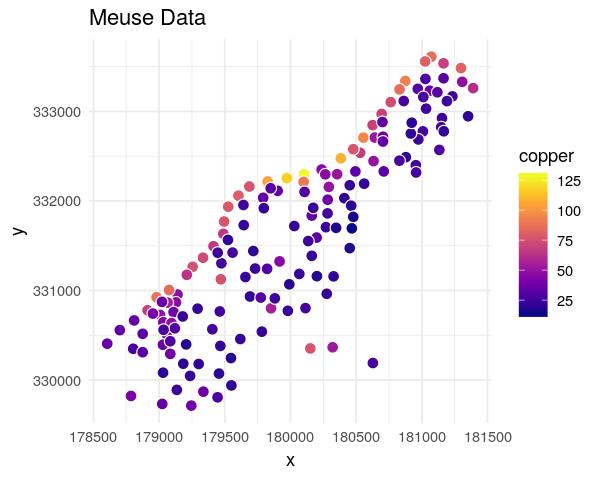

In [39]:
options(repr.plot.width=5, repr.plot.height=4)
plt <- ggplot(meuse, aes(x, y)) + 
          geom_point(aes(fill=copper), colour="white", pch=21, size=3) +
          viridis::scale_fill_viridis(option="plasma", na.value="darkblue") +
          ggtitle("Meuse Data") +
          theme_minimal()
publish_gg(plt)